# COLLECTING TOOLS

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
df=pd.read_csv('/kaggle/input/perrin-freres-monthly-champagne-sales/perrin-freres-monthly-champagne.csv')
df.columns=['month','sales']
df.drop([105,106],inplace=True)
df['month']=pd.to_datetime(df['month'])
df.set_index('month',inplace=True)

# VISUALISE THE DATA

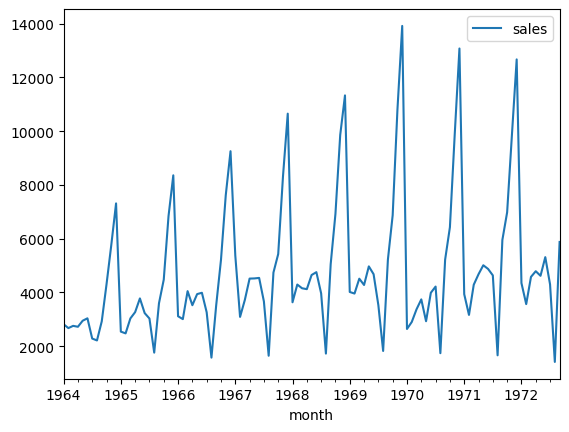

In [4]:
df.plot();

<Figure size 1300x1600 with 0 Axes>

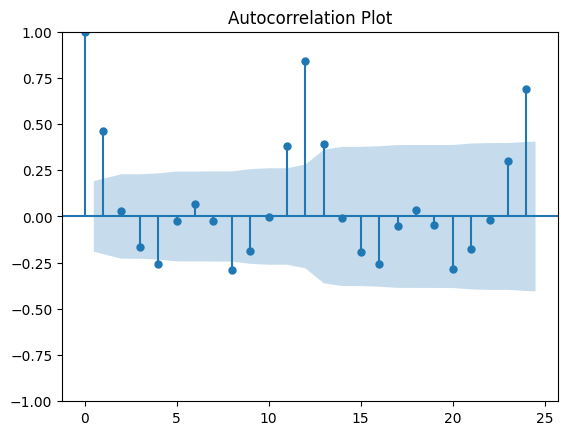

In [5]:
plt.figure(figsize=(13, 16))
plot_acf(df, lags=24)  
plt.title("Autocorrelation Plot")
plt.show();

* From the above Auto-Correlation Plot we can view that the **seasonality** of the data is **12**

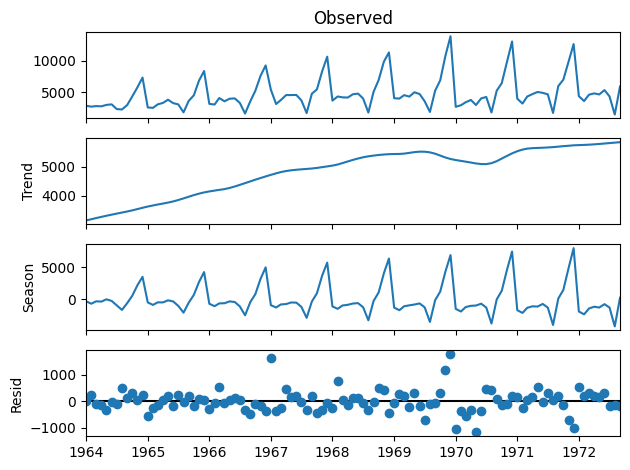

In [6]:
stl=STL(df,seasonal=11)
results=stl.fit()
trends=results.trend
seasonal=results.seasonal
residual=results.resid

results.plot()
plt.show()

In [7]:
def adfuller_test(time_series):
    results=adfuller(time_series)
    labels=['ADA Test Statistic','p-value','#lags_used','Number of observations used']
    for value,label in zip(results,labels):
        print(label+' : '+str(value))
        if results[1]<=0.05:
            print('Time Series is Stationary')
        else:
            print('Time Series is non-Sationary')
        

In [8]:
adfuller_test(df['sales'])

ADA Test Statistic : -1.8335930563276215
Time Series is non-Sationary
p-value : 0.36391577166024586
Time Series is non-Sationary
#lags_used : 11
Time Series is non-Sationary
Number of observations used : 93
Time Series is non-Sationary


# DIFFERENCING:

In [9]:
df['sales_first_difference']=df['sales']-df['sales'].shift(1)

In [10]:
df['sales_seasonal_difference']=df['sales']-df['sales'].shift(12)

In [11]:
df.head(13)

,sales,sales_first_difference,sales_seasonal_difference
month,,,
1964-01-01,2815.0,NaN,NaN
1964-02-01,2672.0,-143.0,NaN
1964-03-01,2755.0,83.0,NaN
1964-04-01,2721.0,-34.0,NaN
1964-05-01,2946.0,225.0,NaN
1964-06-01,3036.0,90.0,NaN
1964-07-01,2282.0,-754.0,NaN
1964-08-01,2212.0,-70.0,NaN
1964-09-01,2922.0,710.0,NaN


In [12]:
adfuller_test(df['sales_first_difference'].dropna())
print("______________________________________")
adfuller_test(df['sales_seasonal_difference'].dropna())

ADA Test Statistic : -7.189896448050999
Time Series is Stationary
p-value : 2.519620447387081e-10
Time Series is Stationary
#lags_used : 11
Time Series is Stationary
Number of observations used : 92
Time Series is Stationary
______________________________________
ADA Test Statistic : -7.626619157213166
Time Series is Stationary
p-value : 2.0605796968136632e-11
Time Series is Stationary
#lags_used : 0
Time Series is Stationary
Number of observations used : 92
Time Series is Stationary


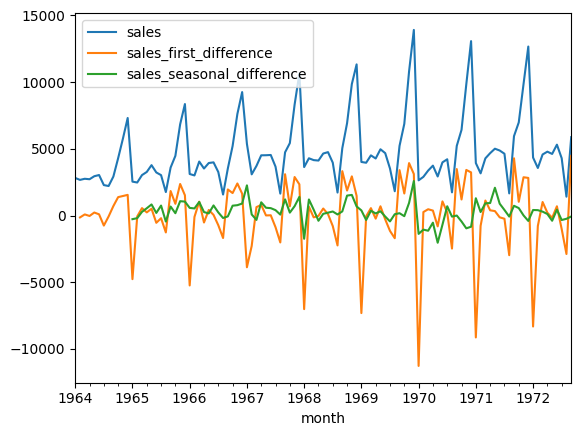

In [13]:
df[['sales','sales_first_difference','sales_seasonal_difference']].plot();

# AUTO REGRESSIVE MODEL

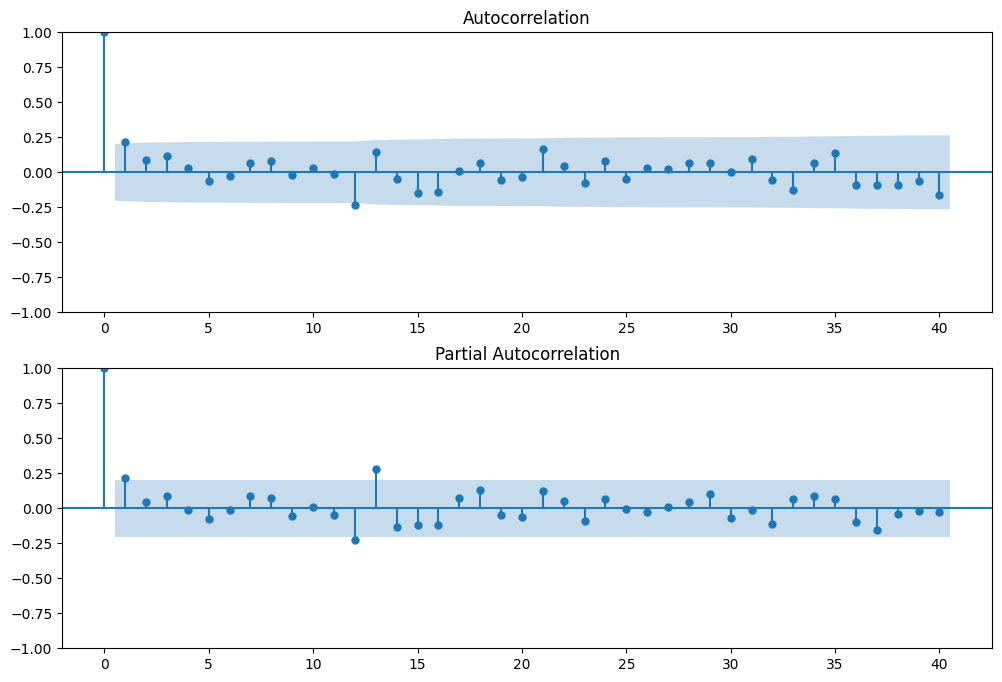

In [14]:
fig,axes=plt.subplots(2,1,figsize=(12,8))
plot_acf(df['sales_seasonal_difference'].iloc[12:],lags=40,ax=axes[0])
plot_pacf(df['sales_seasonal_difference'].iloc[12:],lags=40,ax=axes[1])
plt.show()

In [15]:
model=ARIMA(df['sales'].dropna(),order=(1,1,1))
model_fit=model.fit()

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [16]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                  105
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -952.814
Date:                Wed, 18 Dec 2024   AIC                           1911.627
Time:                        18:26:44   BIC                           1919.560
Sample:                    01-01-1964   HQIC                          1914.841
                         - 09-01-1972                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4545      0.114      4.001      0.000       0.232       0.677
ma.L1         -0.9667      0.056    -17.329      0.000      -1.076      -0.857
sigma2      5.226e+06   6.17e+05      8.472      0.000    4.02e+06    6.44e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):                 2.59
Prob(Q):                              0.34   Prob(JB):                         0.27
Heteroskedasticity (H):               3.40   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='month'>

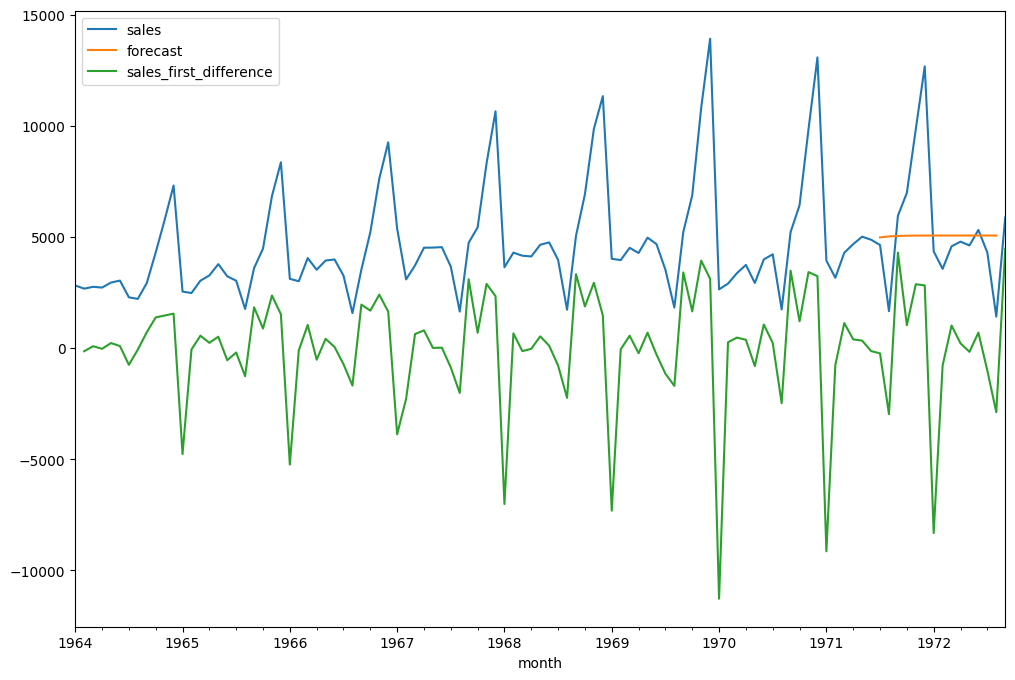

In [17]:
df['forecast']=model_fit.predict(start=90,end=103,dynamic=True)
df[['sales','forecast','sales_first_difference']].plot(figsize=(12,8))

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.07295D+00    |proj g|=  4.80911D-02

At iterate    5    f=  7.04942D+00    |proj g|=  1.53381D-02

At iterate   10    f=  7.04713D+00    |proj g|=  2.99458D-04

At iterate   15    f=  7.04708D+00    |proj g|=  5.05912D-03

At iterate   20    f=  7.04413D+00    |proj g|=  1.18437D-02

At iterate   25    f=  7.03252D+00    |proj g|=  1.05983D-03

At iterate   30    f=  7.03240D+00    |proj g|=  5.98875D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

<Axes: xlabel='month'>

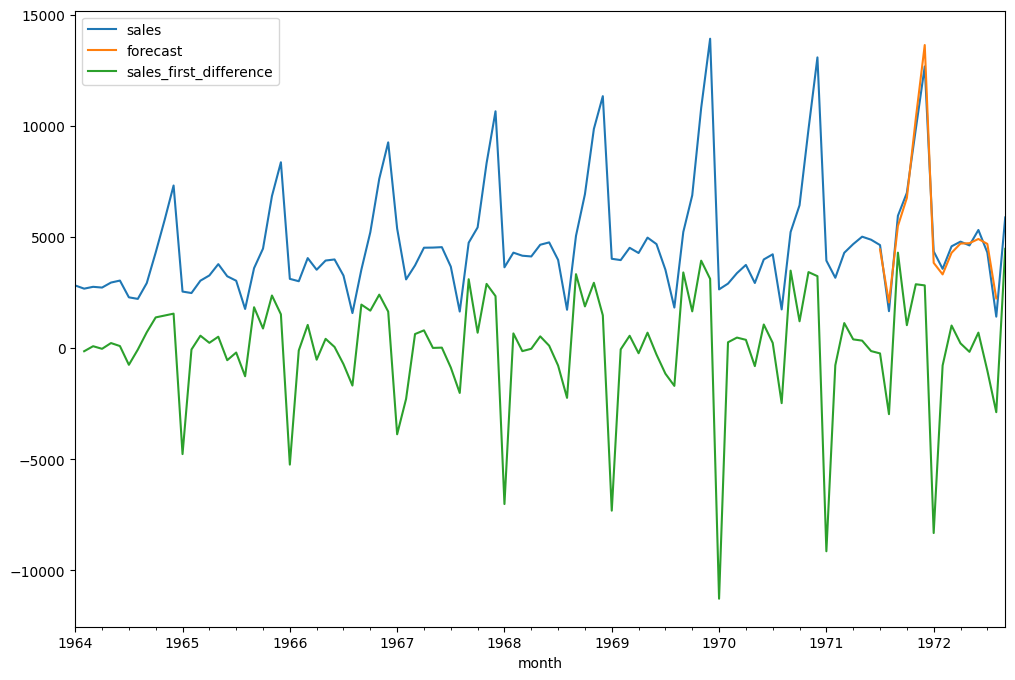

In [18]:
model=SARIMAX(df['sales'].dropna(),order=(1,1,1),seasonal_order=(1,1,1,12))
model_fit=model.fit()
df['forecast']=model_fit.predict(start=90,end=103,dynamic=True)
df[['sales','forecast','sales_first_difference']].plot(figsize=(12,8))

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.07295D+00    |proj g|=  4.80911D-02

At iterate    5    f=  7.04942D+00    |proj g|=  1.53381D-02

At iterate   10    f=  7.04713D+00    |proj g|=  2.99458D-04

At iterate   15    f=  7.04708D+00    |proj g|=  5.05912D-03

At iterate   20    f=  7.04413D+00    |proj g|=  1.18437D-02

At iterate   25    f=  7.03252D+00    |proj g|=  1.05983D-03

At iterate   30    f=  7.03240D+00    |proj g|=  5.98875D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

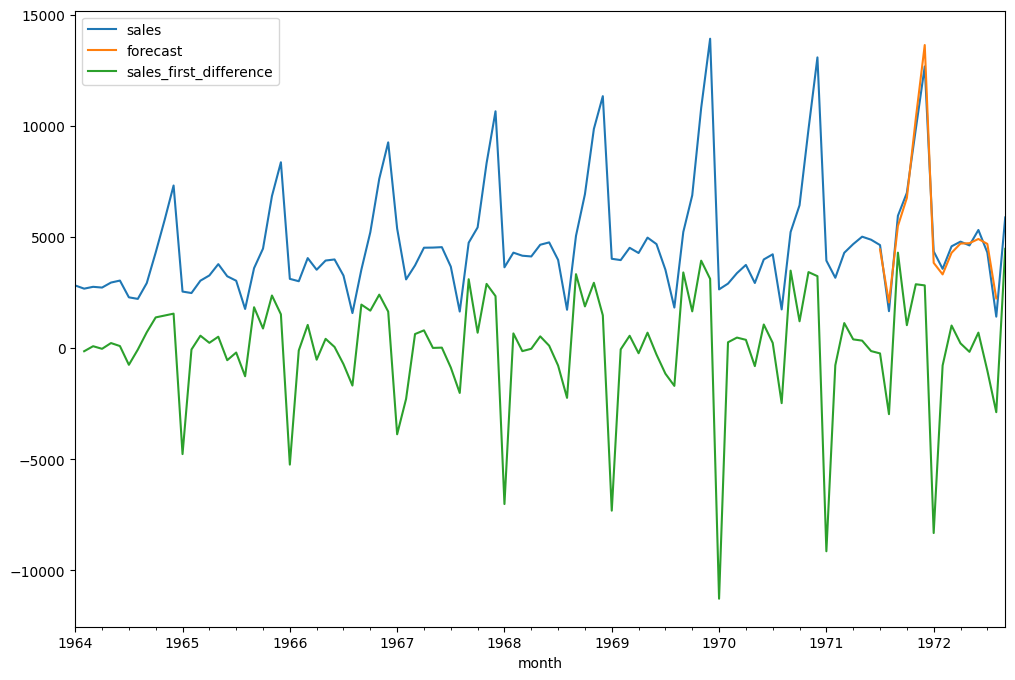

In [19]:
import statsmodels.api as sm

model=sm.tsa.statespace.SARIMAX(df['sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
df['forecast']=model_fit.predict(start=90,end=103,dynamic=True)
df[['sales','forecast','sales_first_difference']].plot(figsize=(12,8))
plt.show()


# MAKING PREDICTIONS


<Axes: >

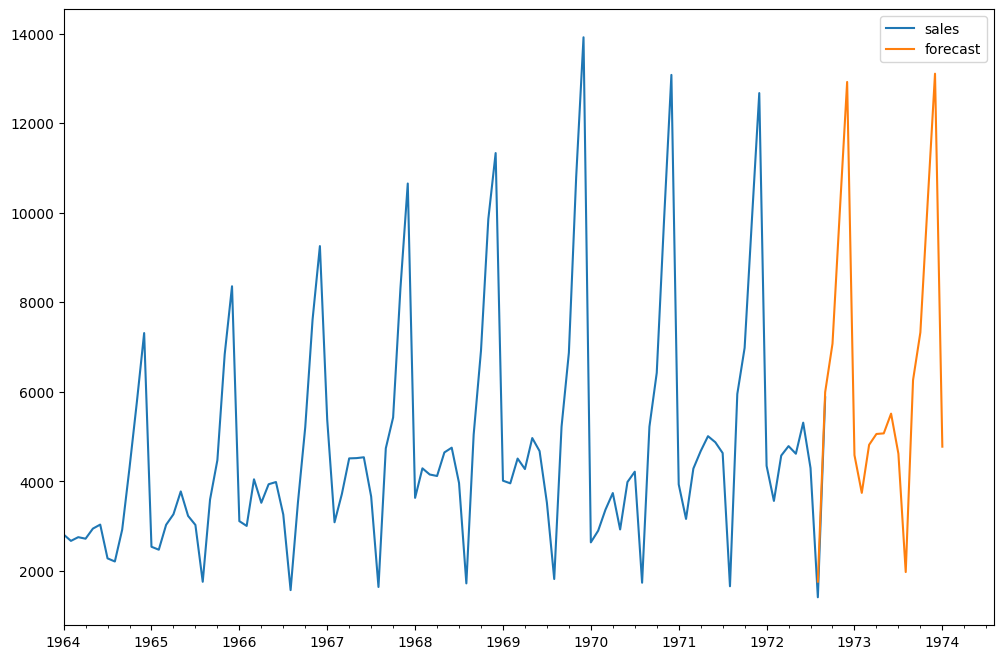

In [25]:
future_df['forecast'] = results.predict(start = 103, end = 120, dynamic= True)  
future_df[['sales', 'forecast']].plot(figsize=(12, 8)) 